**proyecto**
# Análisis de ofertas de empleo para Data Scientist
## Diplomado Ciencia de Datos - modulo I  
  
  
  
  
**Profesora: Carla Paola Malerva Reséndiz**  
**Hernández González Ricardo Paramont**  

**DataSet**:  DataScientist.csv  
    https://www.kaggle.com/andrewmvd/data-scientist-jobs  
    
**Módulo con funciones personales empleadas**: proyecto_hernandez_gonzalez_ricardo_paramont.py

*********

In [1]:
#bibliotecas
import sys
import warnings
import pathlib
from termcolor import colored
#bibliotecas para manejo de datos
import pandas as pd
import numpy as np
from scipy import stats
import re
import unicodedata
import nltk
import unicodedata
from random import sample
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk import FreqDist
from statsmodels.stats.outliers_influence import variance_inflation_factor
#bibliotecas para graficar
import plotly
import plotly.graph_objects as go
import plotly.express as px
import cufflinks as cf
import stylecloud
from PIL import Image
from plotly.offline import plot,iplot
pd.options.plotting.backend = "plotly"
cf.go_offline()
pd.set_option("display.max_columns",200)

### Importación de módulo personal

In [2]:
#La siguiente línea obtiene el path del documento (puede haber problemas si hay un documento con el mismo nombre 
#   que el actual en la misma maquina).
#Despues de estraer el path, lo añade a la lista de paths para buscar modulos.
#Se añade dicho path porque se asume que el modulo necesario para correr el notebook se encuentra en el mismo
#   directorio que el notebook actual.
sys.path.append(  pathlib.Path().parent.absolute()  )
#Importando módulo con funciones a utilizar
from modulo_hernandez_gonzalez_ricardo_paramont import *

### Campos de información

**Job Title**: Nombre de la oferta de trabajo.  
**Salary Estimate**: Rango del salario estimado por el portal Glassdoor, en miles de dólares representado en la notación K.  
**Job Description**: Descripción de distintos rubros de la empresa, puesto y solicitud.  
**Rating**: Calificación por parte de usuarios de la empresa en cuestion. El valor se encuentra entre 1.0 y 5.0, redondeado con un decimal.  
**Company Name**: Nombre de la compañía que ofrece la oferta de trabajo.  
**Location**: Ciudad donde se ubica el trabajo ofertado, junto con el estado o país al que pertenece.  
**Headquarters**: Ciudad y estado/país donde se ubica la sede de la empresa.  
**Size**: Divide a las empresas según su número de empleados en rangos
específicos.  
**Founded**: Año de fundación de la empresa.  
**Type of Ownership**: Tipo de compañía según razón social o identidad.  
**Industry**: Tipo de compañía según idustria en la que trabaja.  
**Sector**: Sector en la que la compañía ofrece sus bienes o servicios.  
**Revenue**: Utilidades de la compañía en dolares al año.  
**Competitors**: Principal compañía competidora de la compañía que ofrece la oferta de trabajo.
**Easy Apply**: Etiqueta que indica si la aplicación por el puesto es sencilla.  
**Salary Minimum**: Rango inferior del estimado del salario. Extraido de Salary Estimate.  
**Salary Maximum**: Rango superior del estimado del salario. Extraido de Salary Estimate.



### Importación del dataset

* Como valores ausentes, contamos con registros de tipo -1 o 'Unknown / Non-Applicable'.  
* De la variable de Salary Estimate extraemos salary minimum y salary maximum desde la importación de los datos por la importancia de dicha información.

In [3]:
#Importando dataset
#   Valores nulos son -1 en esta tabla
df = pd.read_csv("DataScientist.csv",na_values=[-1,'-1','Unknown / Non-Applicable'])
#Eliminando columnas de indice
df = df.drop(df.columns[:2], axis=1)
#Cambiando espacios en nombres de columnas por '_'
# Pasando a minusculas
df.columns = df.columns.str.replace(' ','_').map(str.lower)
#Separando salary_estimate
df[['salary_minimum','salary_maximum']] = df['salary_estimate'].str.split('-', expand=True)
df[['salary_maximum','salary_estimate_source']] = df['salary_maximum'].str.split(' ',1,expand=True)
df.head()

,job_title,salary_estimate,job_description,rating,company_name,location,headquarters,size,founded,type_of_ownership,industry,sector,revenue,competitors,easy_apply,salary_minimum,salary_maximum,salary_estimate_source
0,Senior Data Scientist,$111K-$181K (Glassdoor est.),"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.5,Hopper\n3.5,"New York, NY","Montreal, Canada",501 to 1000 employees,2007.0,Company - Private,Travel Agencies,Travel & Tourism,NaN,NaN,NaN,$111K,$181K,(Glassdoor est.)
1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),"At Noom, we use scientifically proven methods ...",4.5,Noom US\n4.5,"New York, NY","New York, NY",1001 to 5000 employees,2008.0,Company - Private,"Health, Beauty, & Fitness",Consumer Services,NaN,NaN,NaN,$111K,$181K,(Glassdoor est.)
2,Data Science Manager,$111K-$181K (Glassdoor est.),Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,NaN,Decode_M,"New York, NY","New York, NY",1 to 50 employees,NaN,Unknown,NaN,NaN,NaN,NaN,True,$111K,$181K,(Glassdoor est.)
3,Data Analyst,$111K-$181K (Glassdoor est.),Sapphire Digital seeks a dynamic and driven mi...,3.4,Sapphire Digital\n3.4,"Lyndhurst, NJ","Lyndhurst, NJ",201 to 500 employees,2019.0,Company - Private,Internet,Information Technology,NaN,"Zocdoc, Healthgrades",NaN,$111K,$181K,(Glassdoor est.)
4,"Director, Data Science",$111K-$181K (Glassdoor est.),"Director, Data Science - (200537)\nDescription...",3.4,United Entertainment Group\n3.4,"New York, NY","New York, NY",51 to 200 employees,2007.0,Company - Private,Advertising & Marketing,Business Services,NaN,"BBDO, Grey Group, Droga5",NaN,$111K,$181K,(Glassdoor est.)


In [4]:
df.shape

(3909, 18)

# Etiquetado variables

In [5]:
#Defininiendo generador para tener facil acceso al nombre de las 
# columnas con cada invocación.
gen_columns = (col for col in df.columns)

In [6]:
#Revisando tipo de dato y ejemplos de cada columna para decidir 
# su etiqueta.
col = next(gen_columns)
print(col)
print(type(df[col][0]))
print('HEAD\n',df[col].head())
df[col].value_counts()

job_title
<class 'str'>
HEAD
 0                Senior Data Scientist
1    Data Scientist, Product Analytics
2                 Data Science Manager
3                         Data Analyst
4               Director, Data Science
Name: job_title, dtype: object


Data Scientist                                                       274
Data Engineer                                                        260
Data Analyst                                                         246
Senior Data Scientist                                                 91
Machine Learning Engineer                                             47
                                                                    ... 
Process Development Scientist/Engineer - MSAT/Process Development      1
Staff Software Engineer - Data Platform                                1
Scientist - HLA Lab Supervisor                                         1
Senior Digital Analytics Consultant                                    1
Data Analyst/Business Analyst with SQL                                 1
Name: job_title, Length: 2079, dtype: int64

In [7]:
#Definiendo tipo de las columnas.
 #continuas
c_feats = ['salary_minimum','salary_maximum']
 #discretas
v_feats = ['job_title','rating','location','headquarters','size','founded','type_of_ownership','industry','sector','revenue','competitors','easy_apply','salary_estimate_source','salary_estimate']
 #fehcas
d_feats = []
 #texto
t_feats = ['job_description','company_name']

#Etiquetando columnas
df = label_columns(df,c_feats,"c_")
df = label_columns(df,v_feats,"v_")
df = label_columns(df,t_feats,"t_")
df = label_columns(df,d_feats,"d_")

# Duplicados

In [8]:
#Numero de duplicados
df.duplicated().sum()

0

No hay duplicados de facil identidicación en el dataframe.

# Completitud

In [9]:
completitud(df)

,columna,total,completitud
0,v_easy_apply,3745,4.195446
1,v_competitors,2760,29.393707
2,v_revenue,1392,64.389870
3,v_founded,977,75.006395
4,v_sector,546,86.032233
5,v_industry,546,86.032233
6,v_rating,409,89.536966
7,v_headquarters,240,93.860322
8,v_size,229,94.141724
9,v_type_of_ownership,229,94.141724


In [10]:
# eliminando columnas con menos de 80% de completitud
df=df.drop(columns=['v_easy_apply','v_competitors','v_founded','v_revenue'])

# Limpieza de texto

In [11]:
# Limpiando todas las variables que consistan en texto
df['v_job_title'] = df["v_job_title"].map(lambda x:clean_text(x.lower(), pattern="[^a-zA-Z ]",replace=""))
df['v_location'] = df["v_location"].map(lambda x:clean_text(x.lower(), pattern="[^a-zA-Z, ]",replace=""))
df["v_headquarters"] = df["v_headquarters"].map(lambda x:clean_text(x.lower(), pattern="[^a-zA-Z, ]",replace=""),na_action='ignore')
df['v_industry'] = df['v_industry'].map(lambda x:clean_text(x.lower(), pattern="[^a-zA-Z ]",replace=""),na_action='ignore')
df['v_sector'] = df['v_sector'].map(lambda x:clean_text(x.lower(), pattern="[^a-zA-Z ]",replace=""),na_action='ignore')
df['v_type_of_ownership'] = df['v_type_of_ownership'].map(lambda x:clean_text(x.lower(), pattern="[^a-zA-Z-/ ]",replace=""),na_action='ignore')
df['v_size'] = df['v_size'].map(lambda x:clean_text(x.lower(), pattern="[^a-zA-Z0-9 ]",replace=""),na_action='ignore')
df['t_company_name'] = df['t_company_name'].map(lambda x:clean_text(x.lower(), pattern="[^a-zA-Z- ]",replace=""))
df['t_job_description'] = df['t_job_description'].map(lambda x:clean_text(x.lower(), pattern="[^a-zA-Z ]",replace=""))

# Consistencia

**c_salary_minimum & c_salary_maximum**

In [12]:
## Se transforma el salario a flotante
df['c_salary_minimum'] = df['c_salary_minimum'].map(transform_salary)    
df['c_salary_maximum'] = df['c_salary_maximum'].map(transform_salary)    

In [13]:
#Creando columna con media del salario mínimo y máximo por su 
#   importancia para el EDA
# Dicha columna es nuestro objetivo a modelar
df['c_salary_mean'] = df[['c_salary_minimum','c_salary_maximum']].mean(axis=1)
df[['c_salary_minimum','c_salary_maximum','c_salary_mean']].head()

,c_salary_minimum,c_salary_maximum,c_salary_mean
0,111000.0,181000.0,146000.0
1,111000.0,181000.0,146000.0
2,111000.0,181000.0,146000.0
3,111000.0,181000.0,146000.0
4,111000.0,181000.0,146000.0


In [14]:
#Asegurandonos que todos lo valores sobrepasen el salario minimo estadounidense
#Considerando salario minimo = $7.5/h
#   trabajo de medio tiempo = 4h/dia
#   calendario laboral estadounidense en 2019 = 261 dias
salario_minimo = 7.25*4*261
print(df['c_salary_minimum'][df['c_salary_minimum']<salario_minimo])
print(df['c_salary_maximum'][df['c_salary_maximum']<salario_minimo])

Series([], Name: c_salary_minimum, dtype: float64)
Series([], Name: c_salary_maximum, dtype: float64)


In [15]:
#No hay ninguna oferta por debajo del salario mínimo.

In [16]:
#Asegurandonos que salary_maximum es mayor a salary_minimum
df[df['c_salary_minimum']>df['c_salary_maximum']]

,v_job_title,v_salary_estimate,t_job_description,v_rating,t_company_name,v_location,v_headquarters,v_size,v_type_of_ownership,v_industry,v_sector,c_salary_minimum,c_salary_maximum,v_salary_estimate_source,c_salary_mean


**v_rating**

In [17]:
#Transformando a numero
pd.to_numeric(df['v_rating'])
#Verificando valores entre 1 a 5 
df['v_rating'].describe()

count    3500.000000
mean        3.784143
std         0.614619
min         1.000000
25%         3.400000
50%         3.800000
75%         4.100000
max         5.000000
Name: v_rating, dtype: float64

# Normalizacion

### Normalizando v_job_title

In [18]:
df['v_job_title'].value_counts(1)

data scientist                          0.072397
data engineer                           0.069839
data analyst                            0.064978
senior data scientist                   0.023535
machine learning engineer               0.012024
                                          ...   
gilbert data science tutor jobs         0.000256
scientist large molecule                0.000256
pharmaceutical customer data analyst    0.000256
data analyst bhjob                      0.000256
data scientistengineer                  0.000256
Name: v_job_title, Length: 1971, dtype: float64

**Normalizando de tal forma que las únicas categorías sean:**  
- data scientist: cualquier titulo que contanga ambas palabras  
- data analyst: cualquier titulo que contanga ambas palabras  
- data engineer: cualquier titulo que contanga ambas palabras  
- specific discipline scientist: cualquier titulo que contanga la palabra scientist en él, sin contener la palabra data.  
- machine learning professional: cualquier titulo que contanga las palabras machine learning.  
- businesss intelligence analyst: cualquier empleo que contenga las palabras business intelligence.  
- analyst of other nature: cualquier empleo que contenga la palabra analyst sin, sin contener las palabras data o business.
- highly specific: todos los títulos con una sola ocurrencia que no fueron agrupados en las anteriores categorías.
- others: categorías restantes que en conjunto, siguen consistiendo en la categoría de menor frecuencia.

In [19]:
df["v_job_title"] = df["v_job_title"].str.replace(r'(^.*data.*scien.*$)', 'data scientist')
df["v_job_title"] = df["v_job_title"].str.replace(r'(^.*data.*engin.*$)', 'data engineer')
df["v_job_title"] = df["v_job_title"].str.replace(r'(^.*data.*anal.*$)', 'data analyst')
df["v_job_title"] = df["v_job_title"].str.replace(r'(^.*machine.*learning.*$)', 'machine learning professional')
df["v_job_title"] = df["v_job_title"].str.replace(r'(^.*business.* anal.*$)', 'business intelligence analyst')
df["v_job_title"] = df["v_job_title"].str.replace(r'(^((?!data).)*scientist.*$)', 'specific discipline scientist')
df["v_job_title"] = df["v_job_title"].str.replace(r'(^((?!(data)|(business)).)*anal.*$)', 'analyst of other nature')
df["v_job_title"] = df["v_job_title"].str.replace(r'(^.*data.*architect.*$)', 'data architect')
df["v_job_title"] = df["v_job_title"].str.replace(r'(^.*cybersecurity.*$)', 'cybersecurity applied to data science')

#Separando a los trabajos que no pudieron ser agrupados en las categorias de arriba
# y que tinen una sola ocurrencia
counts = pd.DataFrame(df["v_job_title"].value_counts())
one_occurrence = counts[counts['v_job_title']==1].index
dictio = dict(zip(one_occurrence,["highly specific"]*len(one_occurrence)))
df["v_job_title"] = df["v_job_title"].replace(dictio)

#Separando categorias menored en otros
dictio = dict(zip(list(df["v_job_title"].value_counts().index.tolist()[-9:]),["others"]*(9)))
df["v_job_title"] = df["v_job_title"].replace(dictio)

<ipython-input-19-2d3b03722629>:1: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-19-2d3b03722629>:2: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-19-2d3b03722629>:3: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-19-2d3b03722629>:4: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-19-2d3b03722629>:5: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-19-2d3b03722629>:6: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-19-2d3b03722629>:7: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-19-2d3b03722629>:8: FutureWarning:

The default value of regex will 

In [20]:
df['v_job_title'].value_counts(1)

data scientist                   0.298798
data analyst                     0.201074
data engineer                    0.194423
specific discipline scientist    0.186237
machine learning professional    0.031210
analyst of other nature          0.026349
business intelligence analyst    0.023280
highly specific                  0.022512
others                           0.016117
Name: v_job_title, dtype: float64

### Normalizando location

In [21]:
df['v_location'].value_counts(1)

austin, tx         0.088258
chicago, il        0.084421
san diego, ca      0.077769
new york, ny       0.077513
houston, tx        0.056025
                     ...   
carle place, ny    0.000256
summit, nj         0.000256
chula vista, ca    0.000256
lemont, il         0.000256
middletown, nj     0.000256
Name: v_location, Length: 191, dtype: float64

In [22]:
#Crearemos una columna para ciudad y estado a partir de la locacion
# De esta forma, es más sencillo agrupar location por estado y hacer EDA.
df[['v_city','v_state']] = df['v_location'].str.split(', ', expand=True)
#Eliminamos v_location
df = df.drop(columns='v_location')
df[['v_city','v_state']]

,v_city,v_state
0,new york,ny
1,new york,ny
2,new york,ny
3,lyndhurst,nj
4,new york,ny
...,...,...
3904,dublin,oh
3905,columbus,oh
3906,dublin,oh
3907,dublin,oh


### Normalizando v_industry

In [23]:
df['v_industry'].value_counts()

it services                         472
staffing outsourcing                313
biotech pharmaceuticals             293
computer hardware software          264
internet                            238
                                   ... 
truck rental leasing                  1
consumer product rental               1
home furniture housewares stores      1
selfstorage services                  1
religious organizations               1
Name: v_industry, Length: 95, dtype: int64

In [24]:
#Agrupamos los que tienen 3 o menos ocurrencias en la categoria others
counts = pd.DataFrame(df["v_industry"].value_counts())
low_occurrence = counts[counts['v_industry']<=4].index
dictio = dict(zip(low_occurrence,["others"]*len(low_occurrence)))
df["v_industry"] = df["v_industry"].replace(dictio)

In [25]:
print(f"no de categorias: {len(df['v_industry'].value_counts())}")
df["v_industry"].value_counts()

no de categorias: 58


it services                               472
staffing outsourcing                      313
biotech pharmaceuticals                   293
computer hardware software                264
internet                                  238
health care services hospitals            197
consulting                                166
enterprise software network solutions     150
investment banking asset management       109
advertising marketing                      93
insurance carriers                         91
colleges universities                      84
others                                     77
accounting                                 64
banks credit unions                        64
research development                       60
federal agencies                           57
lending                                    41
aerospace defense                          37
video games                                30
architectural engineering services         25
tv broadcast cable networks       

### Normalizando Headquarters

In [26]:
df["v_headquarters"].value_counts()

new york, ny                 297
san diego, ca                179
chicago, il                  158
austin, tx                   106
los angeles, ca               87
                            ... 
boca raton, fl                 1
torrance, ca                   1
macquarie park, australia      1
bryn mawr, pa                  1
melbourne, australia           1
Name: v_headquarters, Length: 540, dtype: int64

In [27]:
#Crearemos una columna para ciudad y estado de los headquarters
df[['v_headquarters_city','v_headquarters_state']] = df['v_headquarters'].str.split(', ',1,expand=True)
#Eliminamos v_lheadquarters
df = df.drop(columns='v_headquarters')
df[['v_headquarters_city','v_headquarters_state']]

,v_headquarters_city,v_headquarters_state
0,montreal,canada
1,new york,ny
2,new york,ny
3,lyndhurst,nj
4,new york,ny
...,...,...
3904,irving,tx
3905,woodridge,il
3906,irving,tx
3907,omaha,ne


In [28]:
#Notamos que hay registros que son de otros paises,
# por lo que creamos la categoria 'another country'
paises = list(filter(lambda text:len(text)>2,df['v_headquarters_state'].dropna()))
paises = dict(zip(paises,['foreign country']*len(paises)))
df['v_headquarters_state']=df['v_headquarters_state'].replace(paises)
df['v_headquarters_state'].value_counts()

ca                 915
tx                 458
ny                 388
foreign country    327
il                 251
nj                 188
pa                 147
va                 118
oh                 103
az                  83
wa                  68
fl                  65
ma                  60
dc                  54
mo                  49
ga                  48
mi                  46
md                  44
ct                  37
ky                  27
nc                  26
mn                  22
ks                  16
wi                  15
in                  13
tn                  13
co                  12
ia                   8
sc                   7
ut                   6
ri                   6
de                   6
or                   5
hi                   5
ne                   4
ms                   3
ok                   3
al                   3
nv                   3
nm                   2
me                   2
id                   2
nh                   2
ak         

### Normalizando v_type_ownership

In [29]:
df['v_type_of_ownership'].value_counts()

company - private                 1933
company - public                  1114
nonprofit organization             207
subsidiary or business segment     160
government                          91
college / university                77
unknown                             38
contract                            17
hospital                            16
private practice / firm             12
other organization                   5
school / school district             5
self-employed                        4
franchise                            1
Name: v_type_of_ownership, dtype: int64

In [30]:
#Reemplazamos franchise por other organization
df['v_type_of_ownership']=df['v_type_of_ownership'].replace({'franchise':'other organization'})

**Revisando dataset nuevamente**

In [31]:
df.head()

,v_job_title,v_salary_estimate,t_job_description,v_rating,t_company_name,v_size,v_type_of_ownership,v_industry,v_sector,c_salary_minimum,c_salary_maximum,v_salary_estimate_source,c_salary_mean,v_city,v_state,v_headquarters_city,v_headquarters_state
0,data scientist,$111K-$181K (Glassdoor est.),about hopperat hopper were on a mission to mak...,3.5,hopper,501 to 1000 employees,company - private,others,travel tourism,111000.0,181000.0,(Glassdoor est.),146000.0,new york,ny,montreal,foreign country
1,data scientist,$111K-$181K (Glassdoor est.),at noom we use scientifically proven methods t...,4.5,noom us,1001 to 5000 employees,company - private,health beauty fitness,consumer services,111000.0,181000.0,(Glassdoor est.),146000.0,new york,ny,new york,ny
2,data scientist,$111K-$181K (Glassdoor est.),decodemhttpswwwdecodemcomdata science manager ...,NaN,decodem,1 to 50 employees,unknown,NaN,NaN,111000.0,181000.0,(Glassdoor est.),146000.0,new york,ny,new york,ny
3,data analyst,$111K-$181K (Glassdoor est.),sapphire digital seeks a dynamic and driven mi...,3.4,sapphire digital,201 to 500 employees,company - private,internet,information technology,111000.0,181000.0,(Glassdoor est.),146000.0,lyndhurst,nj,lyndhurst,nj
4,data scientist,$111K-$181K (Glassdoor est.),director data science descriptionedelman intel...,3.4,united entertainment group,51 to 200 employees,company - private,advertising marketing,business services,111000.0,181000.0,(Glassdoor est.),146000.0,new york,ny,new york,ny


In [32]:
df.dtypes

v_job_title                  object
v_salary_estimate            object
t_job_description            object
v_rating                    float64
t_company_name               object
v_size                       object
v_type_of_ownership          object
v_industry                   object
v_sector                     object
c_salary_minimum            float64
c_salary_maximum            float64
v_salary_estimate_source     object
c_salary_mean               float64
v_city                       object
v_state                      object
v_headquarters_city          object
v_headquarters_state         object
dtype: object

In [33]:
df.describe()

,v_rating,c_salary_minimum,c_salary_maximum,c_salary_mean
count,3500.000000,3909.000000,3909.000000,3909.000000
mean,3.784143,81910.463034,133825.019186,107867.741110
std,0.614619,34310.710234,45011.235698,38639.390034
min,1.000000,10000.000000,26000.000000,18000.000000
25%,3.400000,52000.000000,97000.000000,73000.000000
50%,3.800000,76000.000000,129000.000000,104500.000000
75%,4.100000,110000.000000,165000.000000,133000.000000
max,5.000000,200000.000000,254000.000000,225000.000000


# Analisis Exploratorio de Datos 

### Distribución de puestos ofertados

In [34]:
my_bar_count(df,'v_job_title','Puestos ofertados','','cantidad')

In [35]:
my_pie_count(df,'v_job_title','Puestos ofertados')

### Distribución de la media de la estimación de salarios.

In [36]:
fig_salary_1 = my_histogram(df,'c_salary_mean',50,x_title='salario')
fig_salary_1.show()

### Distribución de salarios de los principales 3 títulos

In [37]:
data_jobs = ['data scientist','data engineer','data analyst']
aux = df[df['v_job_title'].isin(data_jobs)]
my_box(aux,'v_job_title','c_salary_mean','Distribucion del salario de principales 3 puestos',x_title='puesto',y_title='salario')

In [38]:
data_jobs = ['data scientist','data engineer','data analyst']
aux = df[df['v_job_title'].isin(data_jobs)]
fig_salary_2 = px.histogram(aux, x="c_salary_mean", color="v_job_title",marginal='box',
                  color_discrete_sequence=['#6faa9f','#344647','#779a7c'], 
                  )
fig_salary_2.update_layout(title_text='Distribución del salario de distintas ramas <br> de la ciencia de datos',
                  title_font_size=16,
                  title_font_color="#002020",
                  xaxis_title_text='saladio medio',
                  yaxis_title='conteo',
                  plot_bgcolor="rgb(208,208,208)",
                  font=dict(
                     family="Courier New, monospace",size=13)
    )
fig_salary_2.show()

### Principales sectores involucrados en las ofertas de trabajo

In [39]:
my_bar_count(df,'v_sector','Distribución de sectores involucrados','sectores','cantidad')

In [40]:
my_pie_count(df,'v_sector','Distribución de sectores involucrados')

### Distribución del tamaño de las compañías ofertando empleo

In [41]:
my_bar_count(df,'v_size','Distribución del tamaño de las compañías','tamaño','cantidad')

In [42]:
my_pie_count(df,'v_size','Distribución del tamaño de las compañías')

### Distribución del tipo de dueños

In [43]:
my_bar_count(df,'v_type_of_ownership','Tipo de compañía','tipo','cantidad')

In [44]:
my_pie_count(df,'v_type_of_ownership','Tipo de compañía')

### Estados que ofrecen trabajo

In [45]:
my_bar_count(df,'v_state','Estados que ofrecen trabajo','estado','cantidad')

In [46]:
my_pie_count(df,'v_state','Estados que ofrecen trabajo')

### Las 10 ciudades con más ofertas 

In [47]:
fig = my_bar_count(df,'v_city')
fig.update_layout(title_text='Las 10 ciudades con más ofertas de trabajo',
                  title_font_size=16,
                  xaxis_title_text='ciudad',
                  xaxis=dict(range=[0,11]),
                  yaxis_title='conteo',
                 font=dict(
                     family="Courier New, monospace",size=13)
                 )
fig.show()

### Distribución de la ubicación de la sede de las compañías

In [48]:
fig = my_bar_count(df,'v_headquarters_city')
fig.update_layout(title_text='Las 10 ciudades con más sedes de empresas ofertando',
                  title_font_size=16,
                  xaxis_title_text='ciudad',
                  xaxis=dict(range=[0,11]),
                  yaxis_title='conteo',
                 font=dict(
                     family="Courier New, monospace",size=13)
                 )
fig.show()

In [49]:
fig = my_bar_count(df,'v_headquarters_state')
fig.update_layout(title_text='Los 10 estados con más sedes de empresas ofertando',
                  title_font_size=16,
                  xaxis_title_text='Estado',
                  xaxis=dict(range=[0,11]),
                  yaxis_title='conteo',
                 font=dict(
                     family="Courier New, monospace",size=13)
                 )
fig.show()

### Distribución de la calificación de las empresas

In [50]:
fig = my_histogram(df,'v_rating',5,'Calificación de las empresas','calificación','conteo')
fig.update_traces(xbins=dict(
        start=1.0,
        end=5.0,
        size=0.5
    ))

fig.show()

### Palabras más mencionadas en la descripción del trabajo

In [51]:
def text_clean(text, pattern="[^a-zA-Z0-9 ]"):
    text_clean = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    text_clean= re.sub(pattern, " ", text_clean.decode("utf-8"), flags=re.UNICODE)
    text_clean = u' '.join(text_clean.lower().split())
    return text_clean

In [52]:
corpus = " ".join(df['t_job_description'])

In [53]:
lista_stopwords = stopwords.words("english")
texto_clean=text_clean(" ".join(sample(corpus.split(),10000)))
fdist=FreqDist(texto_clean.split())
hapaxes=fdist.hapaxes()

In [54]:
texto_clean=" ".join(list(filter(lambda x:x not in lista_stopwords,texto_clean.split())))

In [55]:
texto_clean=" ".join(list(filter(lambda x:x not in hapaxes,texto_clean.split())))
fdist=FreqDist(texto_clean.split())

/home/paramont/work/envs/diplomado/lib/python3.8/site-packages/stylecloud/stylecloud.py:135: MatplotlibDeprecationWarning:


The makeMappingArray function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. This is not considered public API any longer.



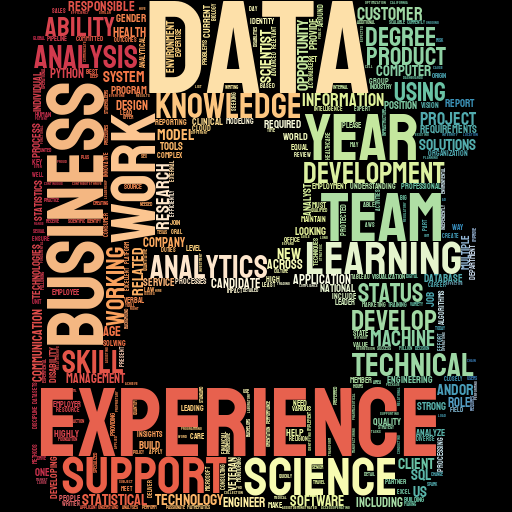

In [56]:
 with open("/home/paramont/work/envs/diplomado/modulo-1/proyecto/graficas/texto-graf.txt","w") as f:
        f.write(texto_clean)
path_texto="/home/paramont/work/envs/diplomado/modulo-1/proyecto/graficas/texto-graf.txt"
path_imagen="/home/paramont/work/envs/diplomado/modulo-1/proyecto/graficas/texto-graf.png"

stylecloud.gen_stylecloud(file_path = path_texto,output_name=path_imagen,icon_name="fas fa-address-book",
                          palette='colorbrewer.diverging.Spectral_11',background_color='black',gradient='horizontal')

Image.open(path_imagen)

### Empresas más comunes

In [57]:
corpus = " ".join(df['t_company_name'])

In [58]:
lista_stopwords = stopwords.words("english")
texto_clean=text_clean(" ".join(corpus.split()))
fdist=FreqDist(texto_clean.split())
hapaxes=fdist.hapaxes()+['inc','corporation','group','llc']
texto_clean=" ".join(list(filter(lambda x:x not in lista_stopwords,texto_clean.split())))
texto_clean=" ".join(list(filter(lambda x:x not in hapaxes,texto_clean.split())))
fdist=FreqDist(texto_clean.split())

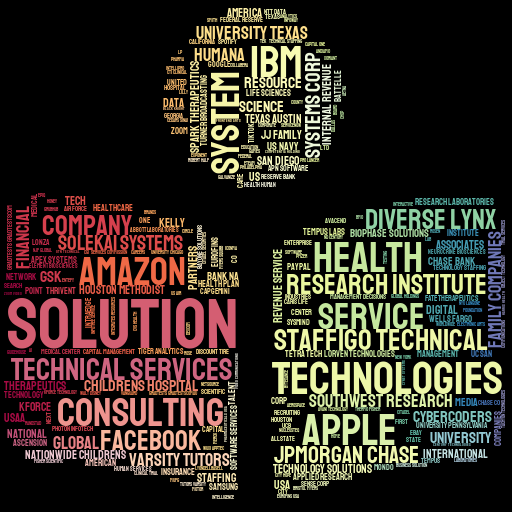

In [59]:
 with open("/home/paramont/work/envs/diplomado/modulo-1/proyecto/graficas/texto-graf.txt","w") as f:
        f.write(texto_clean)
path_texto="/home/paramont/work/envs/diplomado/modulo-1/proyecto/graficas/texto-graf.txt"
path_imagen="/home/paramont/work/envs/diplomado/modulo-1/proyecto/graficas/texto-graf.png"

stylecloud.gen_stylecloud(file_path = path_texto,output_name=path_imagen,icon_name="fas fa-book-reader",
                          palette='colorbrewer.diverging.Spectral_11',background_color='black',gradient='horizontal')

Image.open(path_imagen)

### Correlación entre raiting y salario medio

In [60]:
df[["v_rating","c_salary_mean"]].corr().iplot(kind="heatmap",colorscale='spectral')

# Outliers

In [61]:
#Bucando outliers
feats=list(df.filter(like="c_").columns)
outliers=OUTLIERS(df,feats)
outliers

,features,n_outliers_IQR,n_outliers_Percentil,n_outliers_Z_Score,n_outliers_IQR_%,n_outliers_Percentil_%,n_outliers_Z_Score_%,total_outliers,%_outliers,indices
0,c_salary_minimum,29,363,29,0.74,9.29,0.74,29,0.74,"[2980, 2981, 2982, 2983, 2984, 2985, 2986, 298..."
1,c_salary_maximum,0,352,0,0.00,9.00,0.00,0,0.00,[]
2,c_salary_mean,29,364,29,0.74,9.31,0.74,29,0.74,"[2980, 2981, 2982, 2983, 2984, 2985, 2986, 298..."


In [62]:
#Separandolos
indices=list(outliers[outliers["features"]=="c_salary_mean"]["indices"].values)[0]
aux=df[~df.index.isin(indices)]

In [63]:
#Comparando
#Distribución con outliers
df['c_salary_mean'].iplot(kind='box')

In [64]:
#Distribución sin outliers
aux['c_salary_mean'].iplot(kind='box')

El porcentaje de outliers es tan pequeño que no se nota.relevante
Sin embargo, por ser las ofertas mejor pagadas, su inclusión en el modelo podría resultar relevante.

In [65]:
#Observamos los valores outliers
df.iloc[indices]['c_salary_mean']

2980    225000.0
2981    225000.0
2982    225000.0
2983    225000.0
2984    225000.0
2985    225000.0
2986    225000.0
2987    225000.0
2988    225000.0
2989    225000.0
2990    225000.0
2991    225000.0
2992    225000.0
2993    225000.0
2994    225000.0
2995    225000.0
2996    225000.0
2997    225000.0
2998    225000.0
2999    225000.0
3000    225000.0
3001    225000.0
3002    225000.0
3003    225000.0
3004    225000.0
3005    225000.0
3006    225000.0
3007    225000.0
3008    225000.0
Name: c_salary_mean, dtype: float64

In [66]:
#Observando la diferencia entre los valores outliers y el valor del
#   tercer cuartil más 1.5 veces el rango intercuartílico. (Q3+1.5IQR)
q1 = df['c_salary_mean'].quantile(0.25)
q3 = df['c_salary_mean'].quantile(0.75)
diff = 225000.0 - (q3+1.5*(q3-q1))
diff

2000.0

In [67]:
#La diferencia es tan sólo del 1.85% de la media del salario
2000.0/df['c_salary_mean'].mean()*100

1.8541224460755832

In [68]:
#visulizando a los outliers
fig = my_bar_count(df,'c_salary_mean','Distribución del salario','salario','conteo')
fig.add_vline(x=(q3+1.5*(q3-q1)),
             line_dash='dot',
             annotation_text='Q3+1.5IQR',
             annotation_position='top right')
fig.show()

Los valores outliers son de gran interés, pues representan las ofertas de empleo con mejor paga y además sobrepasan el límite permitido por una cantidad pequeña, por lo que se decide conservar dichos outliers.

# Valores Ausentes

### valores unarios

In [69]:
#Eliminando la coumna de v_salary_estimate_source porque todos los 
#   datos provinen de glassdoor
df = df.drop(columns='v_salary_estimate_source')

In [70]:
from sklearn.model_selection import train_test_split
X_train,X_test=train_test_split(df,test_size=.2,random_state=0)

In [71]:
miss = completitud(X_train)
miss

,columna,total,completitud
0,v_industry,418,86.632555
1,v_sector,418,86.632555
2,v_rating,319,89.798529
3,v_headquarters_state,183,94.147745
4,v_headquarters_city,181,94.211705
5,v_size,174,94.435561
6,v_type_of_ownership,174,94.435561
7,v_job_title,0,100.000000
8,v_salary_estimate,0,100.000000
9,t_job_description,0,100.000000


**v_type_of_ownership**

In [72]:
#Se imputa la moda
X_train['v_type_of_ownership'],X_test['v_type_of_ownership'] = imputar_moda(df,'v_type_of_ownership',X_train,X_test)

Aceptamos HO(La porporción de categorias es la misma que la general)
Se reemplazan los valores ausentes.


**v_size**

In [73]:
#No se puede imputar usando la moda
X_train['v_size'],X_test['v_size'] = imputar_moda(df,'v_size',X_train,X_test)

Rechazamos HO(La porporción de categorias es la misma que la general)


**v_headquarters_city**

In [74]:
#Se imputa la moda
X_train['v_headquarters_city'],X_test['v_headquarters_city'] = imputar_moda(df,'v_headquarters_city',X_train,X_test)

Aceptamos HO(La porporción de categorias es la misma que la general)
Se reemplazan los valores ausentes.


**v_headquarters_state**

In [75]:
#Se imputa la moda
X_train['v_headquarters_state'],X_test['v_headquarters_state'] = imputar_moda(df,'v_headquarters_state',X_train,X_test)

Aceptamos HO(La porporción de categorias es la misma que la general)
Se reemplazan los valores ausentes.


**v_rating**

In [76]:
#No se puede imputar usando la moda
X_train['v_rating'],X_test['v_rating'] = imputar_moda(df,'v_rating',X_train,X_test)

Rechazamos HO(La porporción de categorias es la misma que la general)


In [77]:
#Imputamos como continua
imputar_continua(df,'v_rating')

mean
KstestResult(statistic=0.05527471402989438, pvalue=2.383626695590113e-05)
median
KstestResult(statistic=0.04935562621057633, pvalue=0.00023640167837402082)
mode
KstestResult(statistic=0.10463034024047072, pvalue=4.643773473415137e-18)


In [78]:
imp = SimpleImputer(missing_values=np.nan,strategy="median")
imp.fit(X_train[['v_rating']])
X_train[['v_rating']]=imp.transform(X_train[['v_rating']])
X_test[['v_rating']]=imp.transform(X_test[['v_rating']])

**v_industry**

In [79]:
X_train['v_industry'],X_test['v_industry'] = imputar_moda(df,'v_industry',X_train,X_test)

Rechazamos HO(La porporción de categorias es la misma que la general)


In [80]:
X_train['v_sector'],X_test['v_sector'] = imputar_moda(df,'v_sector',X_train,X_test)

Rechazamos HO(La porporción de categorias es la misma que la general)


**A pesar de que unas variables no pasaron la prueba de chi cuadrada, se les imputa la moda, pues no podemos dejar dichos valores vacíos**

In [81]:
print(X_train['v_size'].mode())
print(X_train['v_industry'].mode())
print(X_train['v_sector'].mode())

0    10000 employees
dtype: object
0    it services
dtype: object
0    information technology
dtype: object


In [82]:
X_train['v_size']=X_train['v_size'].fillna('10000 employees')
X_test['v_size']=X_test['v_size'].fillna('10000 employees')
X_train['v_industry']=X_train['v_industry'].fillna('it services')
X_test['v_industry']=X_test['v_industry'].fillna('it services')
X_train['v_sector']=X_train['v_sector'].fillna('information technology')
X_test['v_sector']=X_test['v_sector'].fillna('information technology')

In [83]:
completitud(X_train)

,columna,total,completitud
0,v_job_title,0,100.0
1,v_salary_estimate,0,100.0
2,t_job_description,0,100.0
3,v_rating,0,100.0
4,t_company_name,0,100.0
5,v_size,0,100.0
6,v_type_of_ownership,0,100.0
7,v_industry,0,100.0
8,v_sector,0,100.0
9,c_salary_minimum,0,100.0


# Ingeniería de variables

**Debido a su importancia para agrupamiento y para el EDA, se crearon las siquientes columnas en secciones anteriores**  
- c_salary_mean  
- v_city, v_state  
- v_headquarters_city, v_headquarters_state

In [84]:
#Se revisa dimensión del df antes de la ingeniería de variables
print(X_train.shape)
X_test.shape

(3127, 16)


(782, 16)

**Creamos la variable dummy v_big_city para indicar si la ciudad de la oferta está dentro de las 20 más grandes de EUA**

In [85]:
#Creamos una variable dummy para indicar si la ciudad está dentro de 
# las 20 ciudades mas pobladas de EUA
top_20_city = list(map(lambda city:city.lower(),
                ['New York','Los Angeles','Chicago','Houston','Phoenix',
                 'Philadelphia[','San Antonio','San Diego','Dallas','San Jose',
                 'Austin','Jacksonville','Fort Worth','Columbus','Charlotte',
                 'San Francisco','Indianapolis','Seattle','Denver','Washington']))

df['v_big_city'] = df['v_city'].isin(top_20_city).astype(int)
df['v_big_city'].value_counts()

1    2588
0    1321
Name: v_big_city, dtype: int64

## Categóricas

### One-Hot encoding / Dummies

In [86]:
feats = ['v_job_title','v_sector','v_size','v_state','v_type_of_ownership']
for col in feats:
    X_train=pd.get_dummies(X_train,columns=[col],prefix=col)
    X_test=pd.get_dummies(X_test,columns=[col],prefix=col)
X_train.head(1)

,v_salary_estimate,t_job_description,v_rating,t_company_name,v_industry,c_salary_minimum,c_salary_maximum,c_salary_mean,v_city,v_headquarters_city,v_headquarters_state,v_job_title_analyst of other nature,v_job_title_business intelligence analyst,v_job_title_data analyst,v_job_title_data engineer,v_job_title_data scientist,v_job_title_highly specific,v_job_title_machine learning professional,v_job_title_others,v_job_title_specific discipline scientist,v_sector_accounting legal,v_sector_aerospace defense,v_sector_arts entertainment recreation,v_sector_biotech pharmaceuticals,v_sector_business services,v_sector_construction repair maintenance,v_sector_consumer services,v_sector_education,v_sector_finance,v_sector_government,v_sector_health care,v_sector_information technology,v_sector_insurance,v_sector_manufacturing,v_sector_media,v_sector_mining metals,v_sector_nonprofit,v_sector_oil gas energy utilities,v_sector_real estate,v_sector_restaurants bars food services,v_sector_retail,v_sector_telecommunications,v_sector_transportation logistics,v_sector_travel tourism,v_size_1 to 50 employees,v_size_10000 employees,v_size_1001 to 5000 employees,v_size_201 to 500 employees,v_size_5001 to 10000 employees,v_size_501 to 1000 employees,v_size_51 to 200 employees,v_size_unknown,v_state_az,v_state_ca,v_state_de,v_state_fl,v_state_il,v_state_nj,v_state_ny,v_state_oh,v_state_pa,v_state_tx,v_state_united kingdom,v_type_of_ownership_college / university,v_type_of_ownership_company - private,v_type_of_ownership_company - public,v_type_of_ownership_contract,v_type_of_ownership_government,v_type_of_ownership_hospital,v_type_of_ownership_nonprofit organization,v_type_of_ownership_other organization,v_type_of_ownership_private practice / firm,v_type_of_ownership_school / school district,v_type_of_ownership_self-employed,v_type_of_ownership_subsidiary or business segment,v_type_of_ownership_unknown
788,$31K-$56K (Glassdoor est.),address w monroe s lasallejob family groupdata...,3.2,bmo,banks credit unions,31000.0,56000.0,43500.0,chicago,chicago,il,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [87]:
#Añadimos columnas que no estan presentes entre los sets.
miss_cols_test = set(X_train.columns)-set(X_test.columns)
for col in miss_cols_test:
    X_test[col]=0
#Asegurando mismo orden de columnas
X_test =X_test[X_train.columns]

### Target encoding

In [88]:
#Codificamos dependiendo la relación entre la categoría y el objetivo
encoder = TargetEncoder()

In [89]:
encoder.fit(X_train[['v_industry','v_city','v_headquarters_city','v_headquarters_state']],X_train['c_salary_mean'])

/home/paramont/work/envs/diplomado/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



TargetEncoder(cols=['v_industry', 'v_city', 'v_headquarters_city',
                    'v_headquarters_state'])

In [90]:
X_train[['v_industry','v_city','v_headquarters_city','v_headquarters_state']] = encoder.transform(X_train[['v_industry','v_city','v_headquarters_city','v_headquarters_state']])
X_test[['v_industry','v_city','v_headquarters_city','v_headquarters_state']] = encoder.transform(X_test[['v_industry','v_city','v_headquarters_city','v_headquarters_state']])

In [91]:
X_train.head(2)

,v_salary_estimate,t_job_description,v_rating,t_company_name,v_industry,c_salary_minimum,c_salary_maximum,c_salary_mean,v_city,v_headquarters_city,v_headquarters_state,v_job_title_analyst of other nature,v_job_title_business intelligence analyst,v_job_title_data analyst,v_job_title_data engineer,v_job_title_data scientist,v_job_title_highly specific,v_job_title_machine learning professional,v_job_title_others,v_job_title_specific discipline scientist,v_sector_accounting legal,v_sector_aerospace defense,v_sector_arts entertainment recreation,v_sector_biotech pharmaceuticals,v_sector_business services,v_sector_construction repair maintenance,v_sector_consumer services,v_sector_education,v_sector_finance,v_sector_government,v_sector_health care,v_sector_information technology,v_sector_insurance,v_sector_manufacturing,v_sector_media,v_sector_mining metals,v_sector_nonprofit,v_sector_oil gas energy utilities,v_sector_real estate,v_sector_restaurants bars food services,v_sector_retail,v_sector_telecommunications,v_sector_transportation logistics,v_sector_travel tourism,v_size_1 to 50 employees,v_size_10000 employees,v_size_1001 to 5000 employees,v_size_201 to 500 employees,v_size_5001 to 10000 employees,v_size_501 to 1000 employees,v_size_51 to 200 employees,v_size_unknown,v_state_az,v_state_ca,v_state_de,v_state_fl,v_state_il,v_state_nj,v_state_ny,v_state_oh,v_state_pa,v_state_tx,v_state_united kingdom,v_type_of_ownership_college / university,v_type_of_ownership_company - private,v_type_of_ownership_company - public,v_type_of_ownership_contract,v_type_of_ownership_government,v_type_of_ownership_hospital,v_type_of_ownership_nonprofit organization,v_type_of_ownership_other organization,v_type_of_ownership_private practice / firm,v_type_of_ownership_school / school district,v_type_of_ownership_self-employed,v_type_of_ownership_subsidiary or business segment,v_type_of_ownership_unknown
788,$31K-$56K (Glassdoor est.),address w monroe s lasallejob family groupdata...,3.2,bmo,94295.918367,31000.0,56000.0,43500.0,85965.779468,85461.538462,89605.769231,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1101,$39K-$87K (Glassdoor est.),monitors and manages large volumes of transact...,2.8,virtus partners,105443.820225,39000.0,87000.0,63000.0,105145.251397,105550.000000,97430.666667,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Texto // Count Vectorizer

**t_job_description**

In [92]:
#Eliminando stop words
stop_words = stopwords.words("english")
X_train["t_job_description"]=X_train["t_job_description"].map(lambda text:" ".join([x for x in text.split(" ") if x not in stop_words]))
X_test["t_job_description"]=X_test["t_job_description"].map(lambda text:" ".join([x for x in text.split(" ") if x not in stop_words]))

In [93]:
corpus_jd = " ".join(df['t_job_description'].values)

In [94]:
# La eliminación de apaches es prácticamente imposible, 
#   pues la lista es enorme, el tiempo de ejecución se extiende demasiado
fdist=FreqDist(corpus_jd.split())
hapaxes=fdist.hapaxes()
len(hapaxes)

43459

No se eliminan hapaxes, pues después de todo, la vectorización se hace sólo para palabras con más del 15% de ocurrencias.

In [95]:
#Tokenizando
X_train["t_job_description"]=X_train["t_job_description"].map(lambda x:x.split())
X_test["t_job_description"]=X_test["t_job_description"].map(lambda x:x.split())

In [96]:
#Lematizando
#nltk.download('wordnet')
lem = nltk.stem.wordnet.WordNetLemmatizer()
X_train["t_job_description"]=X_train["t_job_description"].map(lambda text:[lem.lemmatize(word) for word in text])
X_test["t_job_description"]=X_test["t_job_description"].map(lambda text:[lem.lemmatize(word) for word in text])

In [97]:
#El modelo para vectorizar sólo usa palabras con 15% o más de frecuencia
vect = CountVectorizer(analyzer= 'word', min_df=0.15)
X_train["t_job_description"]=X_train["t_job_description"].map(lambda list:' '.join(word for word in list))
X_test["t_job_description"]=X_test["t_job_description"].map(lambda list:' '.join(word for word in list))
#Entrenando al modelo
vect.fit(X_train['t_job_description'])
#Ajustando ambos sets
array_train = vect.transform(X_train['t_job_description'])
array_test = vect.transform(X_test['t_job_description'])

In [98]:
#Incorporando al dataframe
aux_train=pd.DataFrame(array_train.toarray(),columns=vect.get_feature_names())
aux_test=pd.DataFrame(array_test.toarray(),columns=vect.get_feature_names())
X_train = X_train.reset_index()
X_test = X_test.reset_index()
X_train = pd.concat([X_train,aux_train],axis=1)
X_test = pd.concat([X_test,aux_test],axis=1)
X_train = X_train.set_index('index').sort_index()
X_test = X_test.set_index('index').sort_index()

**t_company_name**

In [99]:
#Eliminando stop words
stop_words = stopwords.words("english")
X_train['t_company_name']=X_train["t_company_name"].map(lambda text:" ".join([x for x in text.split(" ") if x not in stop_words]))
X_test['t_company_name']=X_test["t_company_name"].map(lambda text:" ".join([x for x in text.split(" ") if x not in stop_words]))

In [100]:
corpus_jd = " ".join(df['t_company_name'].values)

In [101]:
#Eliminando hapaxes
fdist=FreqDist(corpus_jd.split())
hapaxes=fdist.hapaxes()
X_train["t_company_name"]=X_train["t_company_name"].map(lambda text:" ".join([x for x in text.split(" ") if x not in hapaxes]))
X_test["t_company_name"]=X_test["t_company_name"].map(lambda text:" ".join([x for x in text.split(" ") if x not in hapaxes]))

In [102]:
#Tokenizando
X_train["t_company_name"]=X_train["t_company_name"].map(lambda x:x.split())
X_test["t_company_name"]=X_test["t_company_name"].map(lambda x:x.split())

In [103]:
#Lematizando
#nltk.download('wordnet')
lem = nltk.stem.wordnet.WordNetLemmatizer()
X_train["t_company_name"]=X_train["t_company_name"].map(lambda text:[lem.lemmatize(word) for word in text])
X_test["t_company_name"]=X_test["t_company_name"].map(lambda text:[lem.lemmatize(word) for word in text])

In [104]:
#El modelo vectoriza sólo palabras que se repiten 5%
vect = CountVectorizer(analyzer= 'word', min_df=0.05)
X_train["t_company_name"]=X_train["t_company_name"].map(lambda list:' '.join(word for word in list))
X_test["t_company_name"]=X_test["t_company_name"].map(lambda list:' '.join(word for word in list))
#Entrenando
vect.fit(X_train["t_company_name"])
#Ajustando
array_train = vect.transform(X_train["t_company_name"])
array_test = vect.transform(X_test["t_company_name"])

In [105]:
aux_train=pd.DataFrame(array_train.toarray(),columns=vect.get_feature_names())
aux_test=pd.DataFrame(array_test.toarray(),columns=vect.get_feature_names())

In [106]:
X_train = X_train.reset_index()
X_test = X_test.reset_index()
X_train = pd.concat([X_train,aux_train],axis=1)
X_test = pd.concat([X_test,aux_test],axis=1)
X_train = X_train.set_index('index').sort_index()
X_test = X_test.set_index('index').sort_index()

In [107]:
# Se revisan dimensiones del df
print(X_train.shape)
X_test.shape

(3127, 360)


(782, 360)

# Reducción de variables

Ya que nuestra variable objetivo proviene del promedio de c_salary_minimum y c_salary_maximum, eliminaremos estas mismas.
Así mismo, borramos las variables de texto que ya se vectorizaron

In [108]:
X_train = X_train.drop(columns=['c_salary_minimum','c_salary_maximum','v_salary_estimate','t_job_description','t_company_name'])
X_test = X_test.drop(columns=['c_salary_minimum','c_salary_maximum','v_salary_estimate','t_job_description','t_company_name'])

### Filtro de alta correlación

In [109]:
correlacion = abs(X_train.filter(regex='^\w_').corr(method="spearman"))

In [110]:
correlacion.iplot(kind="heatmap",colorscale="orrd",title="Matriz de Correlación")

In [111]:
for col in correlacion.columns:
    aux = correlacion[[col]][correlacion[[col]]>0.7].dropna()
    if len(aux)>1:
        display(aux)

,v_headquarters_city
v_headquarters_city,1.000000
v_headquarters_state,0.703432


,v_headquarters_state
v_headquarters_city,0.703432
v_headquarters_state,1.000000


,v_sector_education
v_sector_education,1.000000
v_type_of_ownership_college / university,0.877752


,v_sector_government
v_sector_government,1.000000
v_type_of_ownership_government,0.854227


,v_type_of_ownership_college / university
v_sector_education,0.877752
v_type_of_ownership_college / university,1.000000


,v_type_of_ownership_company - private
v_type_of_ownership_company - private,1.000000
v_type_of_ownership_company - public,0.705439


,v_type_of_ownership_company - public
v_type_of_ownership_company - private,0.705439
v_type_of_ownership_company - public,1.000000


,v_type_of_ownership_government
v_sector_government,0.854227
v_type_of_ownership_government,1.000000


In [112]:
col_drop = ['v_headquarters_city','v_sector_education','v_sector_government','v_type_of_ownership_company - private']

### Correlación con objetivo

In [113]:
correlacion=abs(X_train.corr(method='spearman'))
low_corr = correlacion[correlacion["c_salary_mean"]<0.1][['c_salary_mean']].sort_values(by="c_salary_mean")
low_corr

,c_salary_mean
without,0.000112
sql,0.000589
v_sector_nonprofit,0.000636
group,0.000874
federal,0.001148
...,...
problem,0.094039
quantitative,0.094542
way,0.095716
deep,0.096944


In [114]:
#Eliminando columnas con correlacion menor a 0.1 con el objetivo
X_train = X_train.drop(columns=low_corr.index)
X_test = X_test.drop(columns=low_corr.index)

### Multicolinealidad

In [115]:
high_vif = calc_vif(X_train.drop(columns='c_salary_mean'))
high_vif = high_vif[high_vif['VIF']>10]
high_vif

,variables,VIF
0,v_industry,86.566996
1,v_city,60.621267
2,v_headquarters_city,90.085193
3,v_headquarters_state,111.057827


In [116]:
#Eliminamos variables con VIF mayor a 10
X_train = X_train.drop(columns=high_vif['variables'].values)
X_test = X_test.drop(columns=high_vif['variables'].values)

# Tabla Final

In [117]:
#Renombrando al objetivo
X_train = X_train.rename(columns={'c_salary_mean':'tgt_salary_mean'})
X_test = X_test.rename(columns={'c_salary_mean':'tgt_salary_mean'})

In [118]:
X_train

,tgt_salary_mean,v_job_title_data scientist,v_state_ca,v_state_fl,v_state_il,v_state_ny,v_state_pa,v_state_tx,v_type_of_ownership_company - public,algorithm,learning,machine,phd,product,python,science,scientist,statistic,statistical,team,world
index,,,,,,,,,,,,,,,,,,,,,
0,146000.0,1,0,0,0,1,0,0,0,0,3,3,0,4,0,1,1,1,2,3,3
2,146000.0,1,0,0,0,1,0,0,0,2,2,2,0,3,1,8,1,2,0,9,0
3,146000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4,0
6,146000.0,0,0,0,0,1,0,0,0,0,0,0,3,1,1,2,1,1,0,3,0
7,146000.0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3903,83500.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
3905,83500.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,3,0,0
3906,83500.0,0,0,0,0,0,0,0,0,0,1,1,0,1,2,0,0,0,0,0,0


In [119]:
X_test

,tgt_salary_mean,v_job_title_data scientist,v_state_ca,v_state_fl,v_state_il,v_state_ny,v_state_pa,v_state_tx,v_type_of_ownership_company - public,algorithm,learning,machine,phd,product,python,science,scientist,statistic,statistical,team,world
index,,,,,,,,,,,,,,,,,,,,,
1,146000.0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,2,0,1,3,0
4,146000.0,1,0,0,0,1,0,0,0,0,2,2,0,0,1,3,1,0,1,3,0
5,146000.0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,1,1,0,0
10,146000.0,1,0,0,0,1,0,0,0,1,6,4,0,3,1,1,1,1,3,4,0
14,146000.0,1,0,0,0,1,0,0,0,0,0,0,1,4,0,3,2,1,2,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3876,62500.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3881,62500.0,1,0,0,0,0,0,0,0,0,0,1,0,2,1,5,0,1,0,2,0
3886,83500.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
